In [ ]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, CrossEntropy
import lightning as pl
from lightning.pytorch.tuner import Tuner
import pytorch_optimizer
import matplotlib


contentDataframe = pd.read_excel('data/Online Retail.xlsx')
contentDataframe.dropna(subset=['CustomerID','InvoiceDate'])
contentDataframe = contentDataframe.sort_values(by=["CustomerID"],kind="mergesort") #stable sorting means I can sort by one column instead of two :)


c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#display(contentDataframe)

In [3]:
contentDataframe.dropna(subset=["CustomerID"], inplace=True)
#Predict next purchase, so we want timestep obv where each transaction is one time step
#sort by date time so need to convert
contentDataframe['dateTime'] = pd.to_datetime(contentDataframe['InvoiceDate'])
contentDataframe.sort_values(by='dateTime', kind='mergesort', ascending=False)
contentDataframe['time_idx'] = contentDataframe.groupby(['CustomerID','dateTime']).cumcount()
contentDataframe['totalTxValue'] = contentDataframe['Quantity'] * contentDataframe['UnitPrice'].astype('int')
contentDataframe.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dateTime,time_idx,totalTxValue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18 10:01:00,0,74215
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18 10:17:00,0,-74215
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,2010-12-07 14:57:00,0,24
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,2010-12-07 14:57:00,1,16
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,2010-12-07 14:57:00,2,36


In [4]:
validationRows = []
testingRows = []
for CustomerID, group in contentDataframe.groupby('CustomerID'):
    numberOfRows = len(group)
    last20 = int(np.floor(0.2*numberOfRows))
    last20Rows = group.tail(last20)
    validationSplit = group.head(int(last20 / 2))
    testingSplit = group.tail(int(last20 / 2))
    validationRows.append(validationSplit)
    testingRows.append(testingSplit)
validationDataframe = pd.concat(validationRows, ignore_index=True)
testingDataframe = pd.concat(testingRows,ignore_index=True)

In [5]:
contentDataframe['StockCode'] = contentDataframe['StockCode'].astype("str")
validationDataframe['StockCode'] = validationDataframe['StockCode'].astype("str")

In [6]:
training = TimeSeriesDataSet(
    contentDataframe,
    time_varying_known_reals='time_idx',
    time_idx='time_idx',
    target='Quantity',
    group_ids='CustomerID', #not sure if more data prep can be done to make more use of this
    static_categoricals=['Country'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)
#instatiate data loaders
#configuration for min_prediction length, min_encoder length, min_prediction_idx could yield further improvements as to future forecasting

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:964: UserWarning: Target scales will be only added for continous targets
  warnings.warn(
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2767 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CustomerID': 12346.0}, {'__group_id__CustomerID': 12348.0}, {'__group_id__CustomerID': 12350.0}, {'__group_id__CustomerID': 12352.0}, {'__group_id__CustomerID': 12353.0}, {'__group_id__CustomerID': 12355.0}, {'__group_id__CustomerID': 12358.0}, {'__group_id__CustomerID': 12361.0}, {'__group_id__CustomerID': 12363.0}, {'__group_id__CustomerID': 12365.0}]
  warnings.warn(


In [7]:
validation = TimeSeriesDataSet(
    validationDataframe,
    time_varying_known_reals='time_idx',
    time_idx='time_idx',
    target='Quantity',
    group_ids='CustomerID', #not sure if more data prep can be done to make more use of this
    static_categoricals=['Country'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:964: UserWarning: Target scales will be only added for continous targets
  warnings.warn(
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 3632 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CustomerID': 12347.0}, {'__group_id__CustomerID': 12348.0}, {'__group_id__CustomerID': 12349.0}, {'__group_id__CustomerID': 12350.0}, {'__group_id__CustomerID': 12352.0}, {'__group_id__CustomerID': 12354.0}, {'__group_id__CustomerID': 12355.0}, {'__group_id__CustomerID': 12356.0}, {'__group_id__CustomerID': 12357.0}, {'__group_id__CustomerID': 12358.0}]
  warnings.warn(


In [8]:
batchSize = 128
trainDataloader = training.to_dataloader(
    train=True, batch_size=batchSize, num_workers = 11
)
validationDataloader = validation.to_dataloader(
    train=False, batch_size=batchSize * 10, num_workers = 11
)

In [9]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="auto",
    gradient_clip_val=0.1,
)

TFT = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size=8,
    attention_head_size=3,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer='ranger',
)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an insta

c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Jones\Desktop\CBAProj\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'va

Suggested learning rate  0.8912509381337452


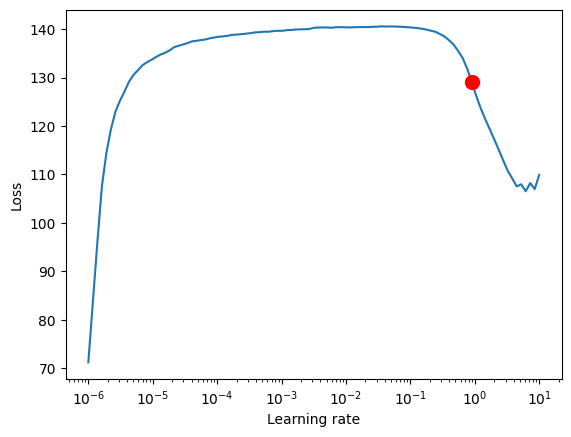

C:\Users\Jones\AppData\Local\Temp\ipykernel_11056\21719391.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [10]:
res = Tuner(trainer).lr_find(
    TFT,
    train_dataloaders=trainDataloader,
    val_dataloaders=validationDataloader,
    max_lr=10.0,
    min_lr=1e-6,
)
print("Suggested learning rate ",res.suggestion())
fig = res.plot(show=True, suggest=True)
fig.show()